In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow import math
from numpy.random import seed
from tensorflow import random

In [2]:
gene_encodings_cancer = pd.read_csv('Gene_freq_encoding_FULL.csv')
gene_encodings_healthy = pd.read_csv('Healthy_Gene_freq_encoding.csv')

In [3]:
gene_encodings_cancer.shape

(5987, 30401)

In [4]:
gene_encodings_healthy.shape

(2504, 30547)

In [5]:
all_patient_genes = pd.concat([gene_encodings_cancer, gene_encodings_healthy]).dropna(axis='columns')

/Users/nima/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
cancer_types = set(all_patient_genes['CancerType'])

In [7]:
label_dict = {}
for i, ct in enumerate(cancer_types):
    label_dict[ct] = i
label_dict

{'LGG-US': 0,
 'OV-US': 1,
 'PRAD-US': 2,
 'GBM-US': 3,
 'COAD-US': 4,
 'BLCA-US': 5,
 'LUSC-US': 6,
 'KIRC-US': 7,
 'Healthy': 8,
 'SKCM-US': 9,
 'BRCA-US': 10,
 'THCA-US': 11,
 'UCEC-US': 12}

In [8]:
cancer_labels = list(label_dict.keys())

In [9]:
all_patient_genes = all_patient_genes.sample(frac=1)

In [10]:
gene_labels = [label for label in all_patient_genes.columns if label.startswith("ENSG")]

In [11]:
datax = all_patient_genes[gene_labels].to_numpy()

In [12]:
def to_categorical(val, n_class=13):
    result = np.zeros(n_class)
    result[val] = 1
    return result

In [13]:
datay = [to_categorical(label_dict[t]) for t in list(all_patient_genes['CancerType'])]
datay = np.array(datay)

In [14]:
seed(1)
random.set_seed(2)

# Model
- Try other initializers

In [15]:
patient_genes = Input(shape=(datax.shape[1],))
layer_1 = Dense(500, activation='relu', kernel_initializer='glorot_normal')(patient_genes)
layer_1_bn = BatchNormalization()(layer_1)
layer_2 = Dense(150, activation='relu', kernel_initializer='glorot_normal')(layer_1_bn)
layer_2_bn = BatchNormalization()(layer_2)
layer_3 = Dense(13, activation='relu', kernel_initializer='glorot_normal')(layer_2_bn)
layer_3_bn = BatchNormalization()(layer_3)
layer_4 = Dense(13, activation='relu', kernel_initializer='glorot_normal')(layer_3_bn)
layer_4_bn = BatchNormalization()(layer_4)
layer_5 = Dense(150, activation='relu', kernel_initializer='glorot_normal')(layer_4_bn)
layer_5_bn = BatchNormalization()(layer_5)
layer_6 = Dense(500, activation='relu', kernel_initializer='glorot_normal')(layer_5_bn)
layer_6_bn = BatchNormalization()(layer_6)
layer_7 = Dense(datax.shape[1], activation='linear', kernel_initializer='glorot_normal', name='ae_output')(layer_6_bn)

# Input from layer 3 (latent representations)
layer_9 = Dense(13, activation='relu', kernel_initializer='glorot_normal')(layer_3)
layer_9_do = Dropout(0.1)(layer_9)
layer_9_bn = BatchNormalization()(layer_9_do)

layer_10 = Dense(25, activation='relu', kernel_initializer='glorot_normal')(layer_9_bn)
layer_10_do = Dropout(0.1)(layer_10)
layer_10_bn = BatchNormalization()(layer_10_do)

layer_11 = Dense(50, activation='relu', kernel_initializer='glorot_normal')(layer_10_bn)
layer_11_do = Dropout(0.1)(layer_11)
layer_11_bn = BatchNormalization()(layer_11_do)

layer_12 = Dense(75, activation='relu', kernel_initializer='glorot_normal')(layer_11_bn)
layer_12_do = Dropout(0.1)(layer_12)
layer_12_bn = BatchNormalization()(layer_12_do)

layer_13 = Dense(100, activation='relu', kernel_initializer='glorot_normal')(layer_12_bn)
layer_13_do = Dropout(0.1)(layer_13)
layer_13_bn = BatchNormalization()(layer_13_do)

layer_14 = Dense(75, activation='relu', kernel_initializer='glorot_normal')(layer_13_bn)
layer_14_do = Dropout(0.1)(layer_14)
layer_14_bn = BatchNormalization()(layer_14_do)

layer_15 = Dense(50, activation='relu', kernel_initializer='glorot_normal')(layer_14_bn)
layer_15_do = Dropout(0.1)(layer_15)
layer_15_bn = BatchNormalization()(layer_15_do)

layer_16 = Dense(25, activation='relu', kernel_initializer='glorot_normal')(layer_15_bn)
layer_16_do = Dropout(0.1)(layer_16)
layer_16_bn = BatchNormalization()(layer_16_do)

layer_17 = Dense(13, activation='softmax', kernel_initializer='glorot_normal', name='cancer_output')(layer_16_bn)

In [16]:
model = Model(inputs=[patient_genes],
              outputs=[layer_7, layer_17],
             )

In [17]:
losses = {'cancer_output': 'categorical_crossentropy',
          'ae_output': 'mse',
         }

opt = RMSprop(learning_rate=0.001, rho=0.8, momentum=0.3)

In [18]:
model.compile(optimizer=opt,
              loss=losses,
              metrics={'cancer_output': ['accuracy', Recall(), Precision()], 
                       'ae_output': 'mse'},
             )

In [19]:
full_raw_data = [(datax[i],datay[i]) for i in range(datay.shape[0])]
np.random.shuffle(full_raw_data)
datax_train = np.array([np.array(x) for (x, _) in full_raw_data])
datay_train = np.array([np.array(y) for (_, y) in full_raw_data])

In [20]:
stand_datax_train = datax_train / np.max(datax_train)

In [21]:
reduce_lr = ReduceLROnPlateau(verbose=1)
model_checkpoint = ModelCheckpoint(filepath='weights.{epoch:02d}--{val_cancer_output_accuracy:.2f}.hdf5',
                                   save_weights_only=True,
                                   monitor='val_cancer_output_accuracy',
                                   mode='max',
                                   save_best_only=True,
                                  )

In [23]:
model.load_weights('weights.50--0.59.hdf5')

In [26]:
history = model.fit(stand_datax_train[500:],
                   {"ae_output": stand_datax_train[500:], "cancer_output": datay_train[500:]},
                   batch_size=32, 
                   epochs=50,
                   validation_split=0.2,
                   callbacks=[reduce_lr, model_checkpoint],
                   )

Train on 6392 samples, validate on 1599 samples
Epoch 1/50
6392/6392 [==============================] - 40s 6ms/sample - loss: 1.4201 - ae_output_loss: 3.2124e-06 - cancer_output_loss: 1.4193 - ae_output_mse: 3.2140e-06 - cancer_output_accuracy: 0.5421 - cancer_output_recall: 0.3900 - cancer_output_precision: 0.8629 - val_loss: 0.9418 - val_ae_output_loss: 3.6655e-06 - val_cancer_output_loss: 0.9419 - val_ae_output_mse: 3.6653e-06 - val_cancer_output_accuracy: 0.7036 - val_cancer_output_recall: 0.4715 - val_cancer_output_precision: 0.9667
Epoch 2/50
6392/6392 [==============================] - 36s 6ms/sample - loss: 0.9350 - ae_output_loss: 3.0304e-06 - cancer_output_loss: 0.9353 - ae_output_mse: 3.0305e-06 - cancer_output_accuracy: 0.6724 - cancer_output_recall: 0.5304 - cancer_output_precision: 0.8776 - val_loss: 0.9296 - val_ae_output_loss: 2.8676e-06 - val_cancer_output_loss: 0.9298 - val_ae_output_mse: 2.8673e-06 - val_cancer_output_accuracy: 0.7048 - val_cancer_output_recall: 0.5

Epoch 17/50
6392/6392 [==============================] - 40s 6ms/sample - loss: 0.4520 - ae_output_loss: 3.1250e-06 - cancer_output_loss: 0.4520 - ae_output_mse: 3.1254e-06 - cancer_output_accuracy: 0.8647 - cancer_output_recall: 0.8356 - cancer_output_precision: 0.8897 - val_loss: 0.7249 - val_ae_output_loss: 2.7492e-06 - val_cancer_output_loss: 0.7250 - val_ae_output_mse: 2.7485e-06 - val_cancer_output_accuracy: 0.7830 - val_cancer_output_recall: 0.7649 - val_cancer_output_precision: 0.7973
Epoch 18/50
6392/6392 [==============================] - 41s 6ms/sample - loss: 0.4491 - ae_output_loss: 3.1768e-06 - cancer_output_loss: 0.4491 - ae_output_mse: 3.1785e-06 - cancer_output_accuracy: 0.8681 - cancer_output_recall: 0.8381 - cancer_output_precision: 0.8933 - val_loss: 0.7703 - val_ae_output_loss: 2.7520e-06 - val_cancer_output_loss: 0.7704 - val_ae_output_mse: 2.7510e-06 - val_cancer_output_accuracy: 0.7667 - val_cancer_output_recall: 0.7492 - val_cancer_output_precision: 0.7789
Epoc

Epoch 33/50
6392/6392 [==============================] - 42s 7ms/sample - loss: 0.3819 - ae_output_loss: 3.2308e-06 - cancer_output_loss: 0.3836 - ae_output_mse: 3.2316e-06 - cancer_output_accuracy: 0.8849 - cancer_output_recall: 0.8689 - cancer_output_precision: 0.9060 - val_loss: 0.7445 - val_ae_output_loss: 2.7598e-06 - val_cancer_output_loss: 0.7446 - val_ae_output_mse: 2.7591e-06 - val_cancer_output_accuracy: 0.7917 - val_cancer_output_recall: 0.7774 - val_cancer_output_precision: 0.8009
Epoch 34/50
6392/6392 [==============================] - 42s 6ms/sample - loss: 0.3708 - ae_output_loss: 3.3049e-06 - cancer_output_loss: 0.3726 - ae_output_mse: 3.3036e-06 - cancer_output_accuracy: 0.8878 - cancer_output_recall: 0.8600 - cancer_output_precision: 0.9110 - val_loss: 0.7409 - val_ae_output_loss: 2.7925e-06 - val_cancer_output_loss: 0.7410 - val_ae_output_mse: 2.7916e-06 - val_cancer_output_accuracy: 0.7967 - val_cancer_output_recall: 0.7861 - val_cancer_output_precision: 0.8068
Epoc

6392/6392 [==============================] - 42s 7ms/sample - loss: 0.4083 - ae_output_loss: 3.2472e-06 - cancer_output_loss: 0.4083 - ae_output_mse: 3.2482e-06 - cancer_output_accuracy: 0.8809 - cancer_output_recall: 0.8597 - cancer_output_precision: 0.9005 - val_loss: 0.7509 - val_ae_output_loss: 2.7403e-06 - val_cancer_output_loss: 0.7510 - val_ae_output_mse: 2.7393e-06 - val_cancer_output_accuracy: 0.7880 - val_cancer_output_recall: 0.7749 - val_cancer_output_precision: 0.7994
Epoch 49/50
6392/6392 [==============================] - 42s 7ms/sample - loss: 0.4188 - ae_output_loss: 3.2755e-06 - cancer_output_loss: 0.4186 - ae_output_mse: 3.2750e-06 - cancer_output_accuracy: 0.8744 - cancer_output_recall: 0.8520 - cancer_output_precision: 0.8951 - val_loss: 0.7391 - val_ae_output_loss: 2.7652e-06 - val_cancer_output_loss: 0.7392 - val_ae_output_mse: 2.7642e-06 - val_cancer_output_accuracy: 0.7992 - val_cancer_output_recall: 0.7899 - val_cancer_output_precision: 0.8112
Epoch 50/50
6392

In [27]:
# Evaluate full network
model.evaluate(stand_datax_train[:500],
               {"ae_output": stand_datax_train[:500], "cancer_output": datay_train[:500]},
               )

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6646555171012879,
 2.073875e-06,
 0.658644,
 2.0812622e-06,
 0.826,
 0.82,
 0.8384458]

In [35]:
model.save_weights('final_epoch_weights_test_0.82.hdf5')

In [29]:
y_pred_cancers = math.round(model(stand_datax_train)[1])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [30]:
preds = [cancer_labels[np.argmax(y_preds)] for y_preds in y_pred_cancers]
true_labels = [cancer_labels[np.argmax(datay)] for datay in datay_train]

In [31]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [32]:
cnf_mat = confusion_matrix(true_labels, preds, labels=cancer_labels)

In [33]:
df_cm = pd.DataFrame(cnf_mat, index = [i for i in cancer_labels],
                  columns = [i for i in cancer_labels])

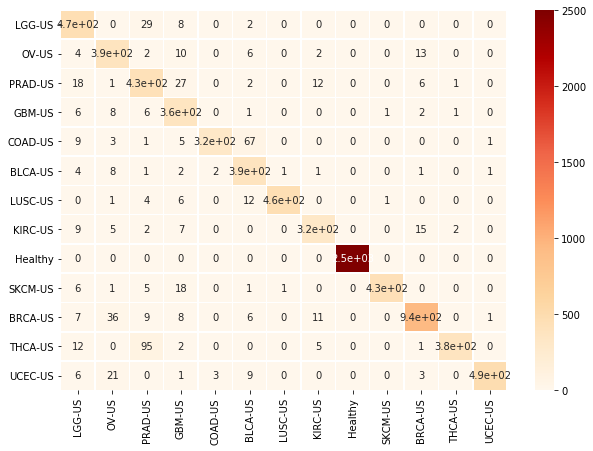

In [34]:
plt.figure(figsize=(10,7))
heatmap(df_cm, cmap='OrRd', linewidths=.5, annot=True)

# Interpretability (In progress)

In [ ]:
# SHAP libraries for neural network
from shap import GradientExplainer
from shap import decision_plot, summary_plot, multioutput_decision_plot

### Might want to try other backgrounds. Plots are not making sense.
### Try LIME

In [ ]:
background = np.zeros((13, stand_datax_train.shape[1]))
summary_background = np.zeros((1, stand_datax_train.shape[1]))
index_to_explain = 23

In [ ]:
explainer = GradientExplainer(full_nn, background)
to_explain = stand_datax_train[index_to_explain]

In [ ]:
print(to_explain)
print(datay_train[index_to_explain])

In [ ]:
list(cancer_types)[np.argmax(datay_train[index_to_explain])]

In [ ]:
prediction_ov = full_nn(stand_datax_train[index_to_explain].reshape(1, stand_datax_train[1].shape[0]))

In [ ]:
list(cancer_types)[np.argmax(prediction_ov)]

## Explain a patient

In [ ]:
to_explain = to_explain.reshape(1, to_explain.shape[0])

In [ ]:
# cannot do entire dataset. Pull one example of interest and perform analysis
shap_vals = explainer.shap_values(X=to_explain, ranked_outputs=None)

In [ ]:
# this won't make sense for one example. Used for whole dataset.
summary_plot(shap_vals, 
             to_explain, 
             gene_names, 
             class_names=list(cancer_types), 
             color=plt.get_cmap("tab20c"),
             max_display=30
            )

In [ ]:
def get_gene_names(gene_codes, ensemble_obj=None):
    gene_names = []
    for gene in gene_codes:
        try:
            gene_info = ensemble_obj.gene_by_id(gene_id=gene)
            gene_names.append(gene_info.gene_name + '(' + gene_info.biotype + ')')
        except ValueError:
            gene_names.append('GENE NOT FOUND')
    return gene_names

In [ ]:
# get class names
list(cancer_types)

In [ ]:
np.unique(to_explain[0], return_index=True, return_counts=True)

In [ ]:
from pyensembl import EnsemblRelease

In [ ]:
gene_names = get_gene_names(gene_labels, ensemble_obj=EnsemblRelease(77))

In [ ]:
cancer_predictions = full_nn(stand_datax_train)

In [ ]:
np.argmax(cancer_predictions[index_to_explain])

In [ ]:
multioutput_decision_plot(base_values=list(background),
                          shap_values=shap_vals,
                          row_index=index_to_explain,
                          feature_names=gene_names,
                          highlight=[np.argmax(cancer_predictions[index_to_explain])],
                          legend_labels=list(cancer_types),
                         )